## 两层网络的实践案例

### 基础库
这里需要导入的库有：

- numpy：这个不用介绍
- h5py 用来分析H5 文件的包.
- matplotlib 不用介绍
- PIL and scipy 用来分析最后的预测结果.
- dnn_utils：作者给定的一些必要的函数：sigmoid, sigmoid_backward, relu, relu_backward
- testCases 测试函数
- np.random.seed(1) 保证随机数的确定性



In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 数据集

这里的问题就是想通过一个模型来判别给出的图片是否为猫。
- 图片的shape(width,hight,3),RGB的图片
- 这里的图片数据是保存在一个“data.h5”的文件中

现在开始来获取训练集和测试集。就是利用上面的给的脚本函数：
- train_set_x_orig ： 训练集orig,表示原始数据，后面我们要对原始数据进行归一化等处理
- traing_set_y：训练集标签
- test_set_x_orig：测试集orig,表示原始数据
- test_set_y：测试集标签
- classes：种类

这些数据的格式通过shape函数就可以获得：
- train_set_x_orig：(209, 64, 64, 3)
    - 209：表示训练样本的个数
    - (64, 64, 3):表示图片size 和channel
- traing_set_y：(1, 209)
- test_set_x_orig：(50, 64, 64, 3)
- test_set_y：(1, 50)
- classes：(2,)
    - non-cat
    - cat

In [2]:
#获取数据集
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y, classes= load_data()

In [3]:
# 训练集的一些信息
# (209, 64, 64, 3):
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)
print(classes[0])
print(classes[1])
print(type(classes))

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)
b'non-cat'
b'cat'
<class 'numpy.ndarray'>


y= [0] non-cat
y= [0] b'non-cat'


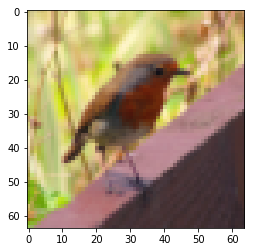

In [6]:
# 显示一张图
index = 10
plt.imshow(train_set_x_orig[index])
print("y=",str(train_set_y[:,index]),classes[np.squeeze(train_set_y[:, index])].decode("utf-8"))
# 没有使用decode
print("y=",str(train_set_y[:,index]),classes[np.squeeze(train_set_y[:, index])])

#### 数据转换

将图片的3D数据转换成1D数据，这样方便使用神经网络的输入。
使用reshape可以很方便的做到：
`X_flatten = X.reshape(X.shape[0],-1).T`
这里的意思是保留第一位数据，-1,：表示到最后的一位变成一个列数据

In [4]:
# 变换数据
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

# 这里的.T表示转置，为了与后面的W相匹配，也方便大家理解输入的神经元
train_set_x_flat = train_set_x_orig.reshape(m_train,-1).T
test_set_x_flat = test_set_x_orig.reshape(m_test,-1).T

print(train_set_x_flat.shape)
print(test_set_x_flat.shape)

(12288, 209)
(12288, 50)


#### 数据的归一化

由于图片的数据是由RGB3个通道组成，且通道的数据范围为0-255，为了方便以后的计算，每次我们都需要对输入的原始数据进行归一化。具体实践如下

In [5]:
#### 数据的归一化
train_x = train_set_x_flat/255.
test_x = test_set_x_flat/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)



### 两层网络的模型结构

其结构图如下：

![](imgs/18.jpg)

下面来总结以下该结构的模型：
- 输入时(64,64,3)的图片，拉伸转换成一个列向量(12288,1)
- 这里的第一层网络隐层层为n1,那么权重W1 shape为(n1,12288)
- 经过第一层的relu激活函数后，A1就变成(n1,1)
- 然后第二层的权重为W2(1,n1)
- 最后经过一层sigmoid激活函数，输出该值。



### L层网络的模型结构

其结构图如下：
![](imgs/19.jpg)

- 输入时(64,64,3)的图片，拉伸转换成一个列向量(12288,1)
- 这里的第一层网络隐层层为n1,那么权重W1 shape为(n1,12288)
- 经过第一层的relu激活函数后，A1就变成(n1,1)
- 循环执行上面两步创建更多的层，
- 最后经过一层sigmoid激活函数，输出该值。

### 创建模型的一般步骤

- 初始化参数并定义超参数
- 循环更新：
    - 前向传播
    - 计算损失值
    - 反向传播
    - 更新参数
- 使用训练的数据预测

### 两层神经网络的创建

其结果的流程如下：
线性-> Relu激活 -> 线性 -> Sigmoid 激活
需要使用上一节定义的一些基础函数如下：

In [15]:
def initialize_parameters(n_x, n_h, n_y):
    """
    输入：
        n_x: 表示输入的数据的个数
        n_h: 中间隐藏层的神经元的个数
        n_y: 表示输出的数据的个数
    """
    
    np.random.seed(1)
    # W1的shape是根据前一层和后一层的维度确定
    W1 = np.random.randn(n_h,n_x) * 0.01
    # b的维度是根据当前层的维度来确定
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    # 辅助判断参数的shape
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters={"W1":W1,
               "b1":b1,
               "W2":W2,
               "b2":b2}
    
    return parameters


def linear_forward(A, W, b):
    """
    输入：
        A:表示前一层的计算结果
        W:表示当前层的权重
        b:表示当前层的偏置
        
    输出：
        Z: 计算结果
        cache:A,W,b的数据
    """
    Z = np.dot(W,A) + b
    
    cache = (A,W,b)
    
    return Z,cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    输入：
    A_prev:表示上一层的激活函数计算的值或者输入层数据
    W,b:表述参数
    activation： 表示当前激活函数样式："sigmoid"&"relu"
    
    输出：
    A:当前层的输出
    cache:缓存linear_cache, activation_cache
    """
    
    if activation == "sigmoid":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    return A,cache

def compute_cost(AL,Y):
    """
    输入：
        AL:最后一层的输出值
        Y:标签数据
    """
    
    m = Y.shape[1]
    # j计算loss值
    cost = -np.sum(np.multiply(np.log(AL),Y)+
                   np.multiply(np.log(1-AL),1-Y))/m
    
    cost = np.squeeze(cost)
    
    return cost


def linear_backward(dZ, cache):
    """
    输入：
        dZ 前一层的Activate导数
        cache: 该层缓存的（A_prev,W,b）
    
    输出：
        dA_prev：loss的梯度
        dW:W的梯度
        db:b的梯度
    """
    A_prev,W,b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev,dW,db


def linear_activation_backward(dA,cache,activation):
    """
    输入：
        dA: 前一层的梯度
        cache: 前向传播缓存的值：linear_cache,activation_catche
        activation: 激活函数的形式
    """
    
    linear_cache, activation_cache = cache
    
    
    if activation == 'relu':
        dZ = relu_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
        
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
        
    return dA_prev,dW,db


def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [7]:
## 创建两层网络的结构

n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

In [10]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    构建一个两层神经网络模型: LINEAR->RELU->LINEAR->SIGMOID.

    输入:
    X -- 输入数据
    Y -- 标签数据 (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- 网络的结构维度 (n_x, n_h, n_y)
    num_iterations -- 循环优化的次数
    learning_rate -- 学习率
    print_cost -- 是否需要每隔100次打印cost值 

    输出:
    parameters -- 字典 W1, W2, b1, and b2
    """
    
    # 基础参数
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x,n_h,n_y) = layers_dims
    
    # 参数初始化
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 开始迭代更新
    for i in range(0,num_iterations):
        # 前向传播第一层
        A1,cache1 = linear_activation_forward(X,
                                              W1,
                                              b1,
                                              activation='relu')
        # 前向传播第二层
        A2,cache2 = linear_activation_forward(A1,
                                             W2,
                                             b2,
                                             activation='sigmoid')
        # 计算loss值
        cost = compute_cost(A2,Y)
        # 计算loss函数的梯度
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        # 计算第二层的梯度
        dA1,dW2,db2 = linear_activation_backward(dA2,
                                                 cache2,
                                                 activation='sigmoid')
         # 计算第一层的梯度
        dA0,dW1,db1 = linear_activation_backward(dA1,
                                                cache1,
                                                activation='relu'
                                                )
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # 更新数据
        parameters = update_parameters(parameters, grads, learning_rate)
       
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # 打印loss 值
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
   
    # 绘制cost图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6434500681370936
Cost after iteration 200: 0.6414437042628797
Cost after iteration 300: 0.6347160978826792
Cost after iteration 400: 0.6173814630487935
Cost after iteration 500: 0.5838741760485857
Cost after iteration 600: 0.5324298290317827
Cost after iteration 700: 0.4708930107796538
Cost after iteration 800: 0.40906176953905693
Cost after iteration 900: 0.43255178599158595
Cost after iteration 1000: 0.396088405248911
Cost after iteration 1100: 0.3644262509969618
Cost after iteration 1200: 0.33850642396949965
Cost after iteration 1300: 0.30437664621719485
Cost after iteration 1400: 0.2764476484724279
Cost after iteration 1500: 0.2394740176206378
Cost after iteration 1600: 0.21648491662223188
Cost after iteration 1700: 0.11657705851785018
Cost after iteration 1800: 0.10014662862682322
Cost after iteration 1900: 0.083802144896121
Cost after iteration 2000: 0.071657834547891
Cost after iteration 2100: 0.0614231902821

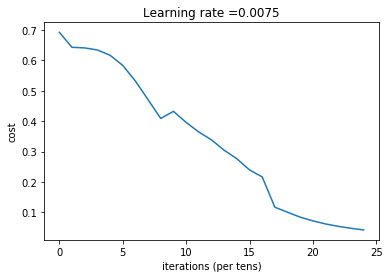

In [16]:
parameters = two_layer_model(train_x, train_set_y,
                             layers_dims = (n_x, n_h, n_y), 
                             num_iterations = 2500, 
                             print_cost=True)

### 使用训练的值进行预测

下面进行值预测，需要使用如下coding.
训练的数据基本上能够完成100%的正确，但是测试数据只有72%，说明该模型已经过拟合了，但是泛化能力还是不行。所以我们需要更加深的网络来实现高精度的预测。

In [17]:
def predict(X, y, parameters):
    """
    L 层网络的预测

    输入:
    X -- 需要预测的值
    parameters -- 模型训练的参数

    返回:
    p -- 预测的精度
    """

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

In [19]:
# 预测训练数据的精度
predict(train_x, train_set_y, parameters)
# 预测测试数据的精度
predict(test_x, test_set_y, parameters)

Accuracy: 0.9952153110047844
Accuracy: 0.72


array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 0.]])